In [1]:
import pandas as pd
import numpy as np
import scipy
import matplotlib
from matplotlib import colors
import matplotlib.pyplot as plt
import os
import os.path as path
import seaborn as sns
import space_fortress_learning_pipeline
import utils_space_fortress
from tqdm import tqdm
from collections import defaultdict
sns.reset_orig()
from IPython.display import display, HTML

%matplotlib inline
%load_ext autoreload

%autoreload 2
matplotlib.rcParams['figure.figsize'] = (20.0, 10.0)
matplotlib.rcParams["font.size"] = "30"
sns.set(font_scale=2)

def background_gradient(s, m, M, cmap='PuBu', low=0, high=0):
    rng = M - m
    norm = colors.Normalize(m - (rng * low),
                            M + (rng * high))
    normed = norm(s.values)
    c = [colors.rgb2hex(x) for x in plt.cm.get_cmap(cmap)(normed)]
    return ['background-color: %s' % color for color in c]

In [52]:
df = pd.read_csv('Data/df_stats_bio_all_phase.csv')
df['participant_id'] = df.participant + df.phase*100
df = df[df['niveau_de_complexite']==4].dropna()

In [53]:
features_columns = ['ActivityInVmu',
       'BreathingWaveAmplitudeInLsb',
       'HeartRateInBpm',
       'HeartRateVariabilityInMillisecond', 'LateralMinimumAccelerationInG',
       'LateralPeakAccelerationInG', 'PeakAccelerationInG', 'PostureInDegree',
       'RespirationRateInBpm', 'SagittalMinimumAccelerationInG',
       'SagittalPeakAccelerationInG',
       'SkinTemperatureInDegree',
       'VerticalMinimumAccelerationInG', 'VerticalPeakAccelerationInG',
       'LongWindowPowerBands_HFPowerBand', 'LongWindowPowerBands_HRVPowerBand',
       'LongWindowPowerBands_LFHFPowerBand',
       'LongWindowPowerBands_LFPowerBand', 'LongWindowPowerBands_ULFPowerBand',
       'LongWindowPowerBands_VLFPowerBand',
       'ShortWindowPowerBands_HFPowerBand',
       'ShortWindowPowerBands_HRVPowerBand',
       'ShortWindowPowerBands_LFHFPowerBand',
       'ShortWindowPowerBands_LFPowerBand',
       'ShortWindowPowerBands_ULFPowerBand',
       'ShortWindowPowerBands_VLFPowerBand',
       'FixationRatioLongWindow', 'FixationRatioShortWindow',
       'FixationRatioStandardDeviation', 'FixationTimeVariation',
       'InvoluntaryFixationRatioLongWindow',
       'InvoluntaryFixationRatioShortWindow',
       'InvoluntaryFixationRatioStandardDeviation',
       'InvoluntaryFixationTimeVariation',
       'MBlink_BlinkDurationAverageLongWindowInSecond',
       'MBlink_BlinkDurationAverageShortWindowInSecond',
       'MBlink_BlinkDurationStandardDeviationLongWindowInSecond',
       'MBlink_BlinkDurationStandardDeviationShortWindowInSecond',
       'MBlink_BlinkFrequencyLongWindowInHertz',
       'MBlink_BlinkFrequencyShortWindowInHertz',
       'MeanVelocityInDegBySecondLongWindow',
       'MeanVelocityInDegBySecondShortWindow', 'PupilDilatationAverageInPixel',
       'PupilDilatationInPixel',
       'PupilDilatationSlopeInPixelPerSecond',
       'PupilDilatationStandardDeviationInPixel', 'PupilSizeAverageInPixel',
       'PupilSizeInPixel',
       'PupilSizeStandardDeviationInPixel', 'SaccadeRatioLongWindow',
       'SaccadeRatioShortWindow']

In [85]:
def std_or_one(se):
    st = se.std()
    if np.isnan(st):
        return 1
    else:
        return st

In [86]:
df_stand_features = df.groupby(('participant', 'phase'))[features_columns].transform(lambda x: (x - x.mean()) / std_or_one(x))

In [151]:
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.dummy import DummyRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.preprocessing import RobustScaler, Imputer

In [88]:
y = df.stand_score_performance
X = df_stand_features.dropna(axis=1, thresh=300)

groups = df['participant_id']
X_train, X_test, y_train, y_test, group_train, group_test = train_test_split(X, y, groups, train_size=0.8)

imp = Imputer(axis=1)
rsc = RobustScaler()

X_train = rsc.fit_transform(imp.fit_transform(X_train))
X_test  = rsc.transform(imp.transform(X_test))

In [152]:
model = MLPRegressor(hidden_layer_sizes=(100, 30 ,10))

In [153]:
cross_val_score(model, X_train, y=y_train, groups=group_train, cv=3, n_jobs=6, scoring='neg_mean_absolute_error')

array([-1.42767154, -1.34688303, -1.24429967])

In [154]:
cross_val_score(DummyRegressor(), X_train, y=y_train, groups=group_train, cv=3, n_jobs=6, scoring='neg_mean_absolute_error')

array([-1.19753139, -1.13422345, -0.96466037])

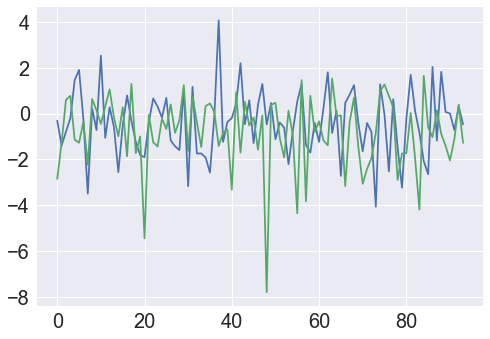

In [155]:
model.fit(X_train, y_train)
plt.plot(model.predict(X_test))
plt.plot(y_test.values)